In [16]:
import csv
import os
import numpy as np
import tensorflow as tf
import visualkeras as visualkeras
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

RANDOM_SEED = 42

In [17]:
dataset_test = 'glove_data_test/glove_test_data.csv'
dataset_test_occlusion = 'glove_data_test/test_data_hand_behind_other.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [18]:
NUM_CLASSES = 24

In [19]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))
X_test_occlusion = np.loadtxt(dataset_test_occlusion, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4,151)))
y_test_occlusion = np.loadtxt(dataset_test_occlusion, delimiter=',', dtype='int32', usecols=(0))

In [20]:
# Mapping dictionary for transforming y values
label_mapping = {
    15: 6,
    19: 7,
    14: 9
}

# Apply label mapping to y_train and y_validation
y_train = np.array([label_mapping.get(label, label) for label in y_train])
y_validation = np.array([label_mapping.get(label, label) for label in y_validation])
y_test = np.array([label_mapping.get(label, label) for label in y_test])
y_test_occlusion = np.array([label_mapping.get(label, label) for label in y_test_occlusion])

In [21]:
print("X dataset shape: " + X_dataset.shape.__str__())
print("y dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X test dataset shape: " + X_test.shape.__str__())
print("y test dataset shape: " + y_test.shape.__str__())
print("----------------------------------")
print("X dataset test occlusion shape: " + X_test_occlusion.shape.__str__())
print("y dataset test occlusion shape: " + y_test_occlusion.shape.__str__())

X dataset shape: (28800, 172)
y dataset shape: (28800,)
----------------------------------
X test dataset shape: (2400, 172)
y test dataset shape: (2400,)
----------------------------------
X dataset test occlusion shape: (2400, 172)
y dataset test occlusion shape: (2400,)


In [22]:
from keras import Sequential

model = Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6036 - loss: 1.1105
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6038 - loss: 1.1098 - val_accuracy: 0.8503 - val_loss: 0.4860
Epoch 2/1000
154/158 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6497 - loss: 0.9755
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6497 - loss: 0.9757 - val_accuracy: 0.8397 - val_loss: 0.5073
Epoch 3/1000
155/158 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6616 - loss: 0.9224
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6617 - loss: 0.9225 - val_accuracy: 0.8588 - val_loss: 0.4881
Epoch 4/1000
154/158 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6659 - loss: 0.9261
Epoch 4: saving model to model/keypoint_c

In [34]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size = 8)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9455 - loss: 0.1337


In [35]:
val_loss, val_acc = model.evaluate(X_test_occlusion, y_test_occlusion, batch_size=8)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8788 - loss: 0.3377


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


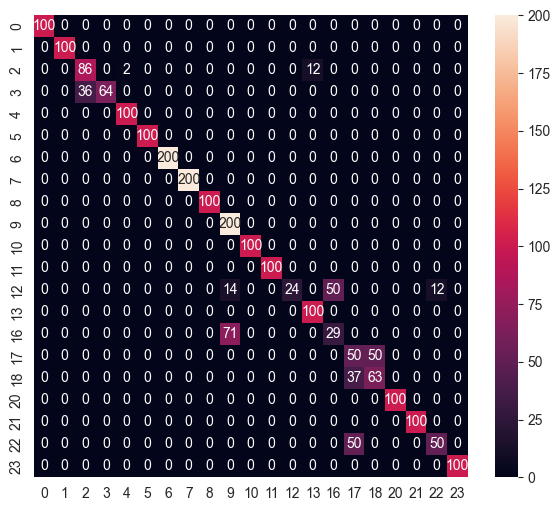

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.70      0.86      0.77       100
           3       1.00      0.64      0.78       100
           4       0.98      1.00      0.99       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       200
           7       1.00      1.00      1.00       200
           8       1.00      1.00      1.00       100
           9       0.70      1.00      0.82       200
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      0.24      0.39       100
          13       0.89      1.00      0.94       100
          16       0.37      0.29      0.32       100
          17       0.36      0.50      0.42       100
          18       0.56      0.63      0.59       100
     

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

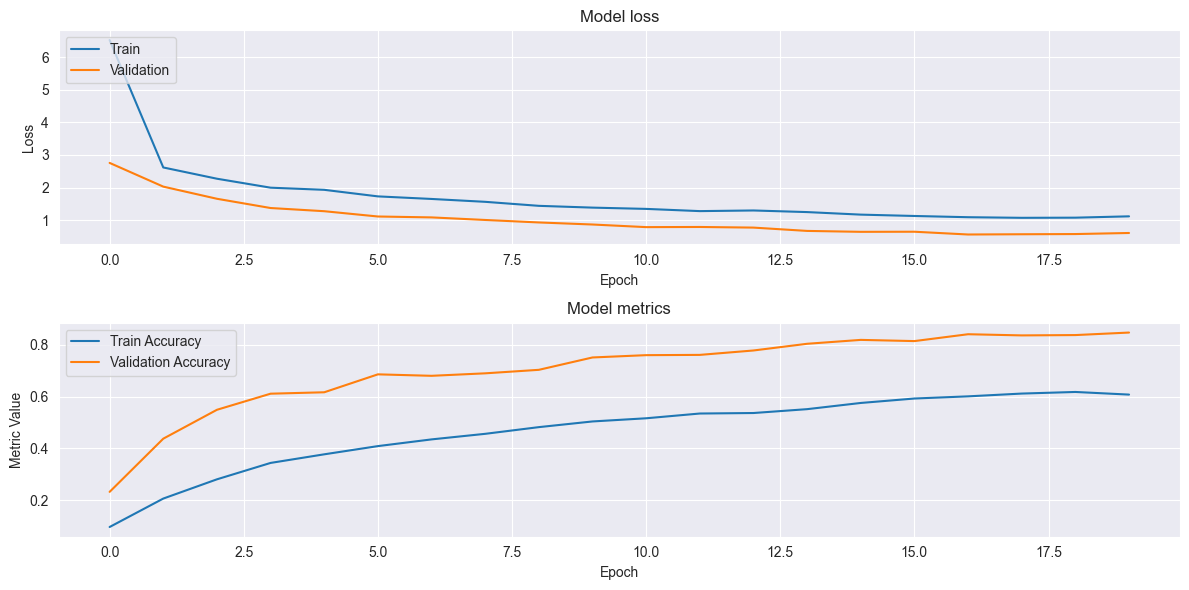

In [30]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()